In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

from utilities.script.image_utils import load_numpy_dataset, show_image_number, dataset_ratio_check

In [2]:
# Load dataset based on K-fold
K = 4
train_dataset_load_path = np.load("utilities/data/"+ str(K) + "/train_"+ str(K) + ".npz")
test_dataset_load_path = np.load("utilities/data/"+ str(K) + "/test_"+ str(K) + ".npz")

train_dataset, test_dataset = load_numpy_dataset(train_dataset_load_path, test_dataset_load_path, K)

x_train, y_train = train_dataset
x_test, y_test = test_dataset

['paper' 'rock' 'scissors']
Corresponding label : rock


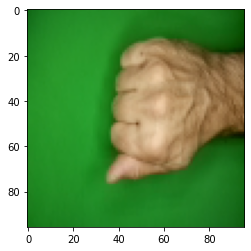

In [3]:
# Show loaded sample
SAMPLE_INDEX = 300
show_image_number(x_test[SAMPLE_INDEX], y_test[SAMPLE_INDEX])

In [4]:
dataset_ratio_check(y_test)

Class=0, n=188 (34.559%)
Class=1, n=181 (33.272%)
Class=2, n=175 (32.169%)


In [5]:
y_train_numeric, y_test_numeric = y_train.copy(), y_test.copy()

In [5]:
# Load Model Configuration
MODEL_PATH = "weight/shallow/"
SAVED_CONFIGURATION_NAME = "shallow_4.json"

json_file = open(MODEL_PATH + SAVED_CONFIGURATION_NAME, 'r')
loaded_model_json = json_file.read()
json_file.close()
classifier = tf.keras.models.model_from_json(loaded_model_json)

#classifier.load_weights(MODEL_PATH + SAVED_WEIGHT_NAME)

classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 16)       0

In [6]:
def generate_adversary_example(model, image, label, epsilon=2/255.0):
    image = tf.cast(image, dtype=tf.float32)
    cross_entropy = tf.keras.losses.CategoricalCrossentropy()

    with tf.GradientTape() as tape:
        tape.watch(image)

        pred = model(image)
        loss = cross_entropy(label, pred)

        gradient = tape.gradient(loss, image)
        signed_gradient = tf.sign(gradient)

        adversary_example = (image + (signed_gradient * epsilon)).numpy()

        return adversary_example

In [7]:
def generate_adversarial_batch(model, total_batch, images, labels, dims, epsilon=0.01):
    (h, w, c) = dims

    while True:
        pertubated_images = []
        pertubated_labels = []

        rand_idx = np.random.choice(range(0, len(images)), size=total_batch, replace=False)

        for idx in rand_idx:
            image = images[idx]
            label = labels[idx]

            image = image.reshape(1, h, w, c)
            adversary_example = generate_adversary_example(model, image, label, epsilon)

            pertubated_images.append(adversary_example)
            pertubated_labels.append(label)

        yield (np.array(pertubated_images), np.array(pertubated_labels))
